In [178]:
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from PIL import Image
from tqdm import tqdm
import random
import seaborn as sns

In [179]:
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/flrlx/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1


In [180]:
dataset_path = path + "/PetImages"
dog_path = os.path.join(dataset_path, "Dog")
cat_path = os.path.join(dataset_path, "Cat")

# общее количество изображений
dog_images = [f for f in os.listdir(dog_path) if os.path.isfile(os.path.join(dog_path, f))]
cat_images = [f for f in os.listdir(cat_path) if os.path.isfile(os.path.join(cat_path, f))]

print(f"Total dog images: {len(dog_images)}")
print(f"Total cat images: {len(cat_images)}")

Total dog images: 12499
Total cat images: 12499


In [181]:
def load_images(directory, num_samples, img_size):
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) 
                  and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # выбираем случайные изображения
    if len(image_files) > num_samples:
        image_files = random.sample(image_files, num_samples)
    
    images = []
    valid_files = []
    
    for img_file in tqdm(image_files):
        img_path = os.path.join(directory, img_file)
        try:
            # ресайз изображения
            img = Image.open(img_path).convert('RGB')
            img = img.resize(img_size)
            img_array = np.array(img)
            # раскладываем изображение в одномерный массив
            images.append(img_array.flatten())
            valid_files.append(img_file)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    return np.array(images), valid_files

In [ ]:
samples_per_class = 1000

print("Loading dog images...")
dog_data, dog_files = load_images(dog_path, num_samples=samples_per_class, img_size=(96,96))
print("Loading cat images...")
cat_data, cat_files = load_images(cat_path, num_samples=samples_per_class, img_size=(96,96))

# матрица признаков и вектор таргетов
X = np.vstack((dog_data, cat_data))
y = np.hstack((np.zeros(len(dog_data)), np.ones(len(cat_data))))

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Dog images loaded: {len(dog_data)}")
print(f"Cat images loaded: {len(cat_data)}")

Loading dog images...


100%|██████████| 1000/1000 [00:02<00:00, 376.87it/s]


Loading cat images...


100%|██████████| 1000/1000 [00:02<00:00, 409.28it/s]

X shape: (2000, 27648)
y shape: (2000,)
Dog images loaded: 1000
Cat images loaded: 1000


In [ ]:
# 80/20 разбиение
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

print(f"Training set: {X_train.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

Training set: 1600 images
Test set: 400 images


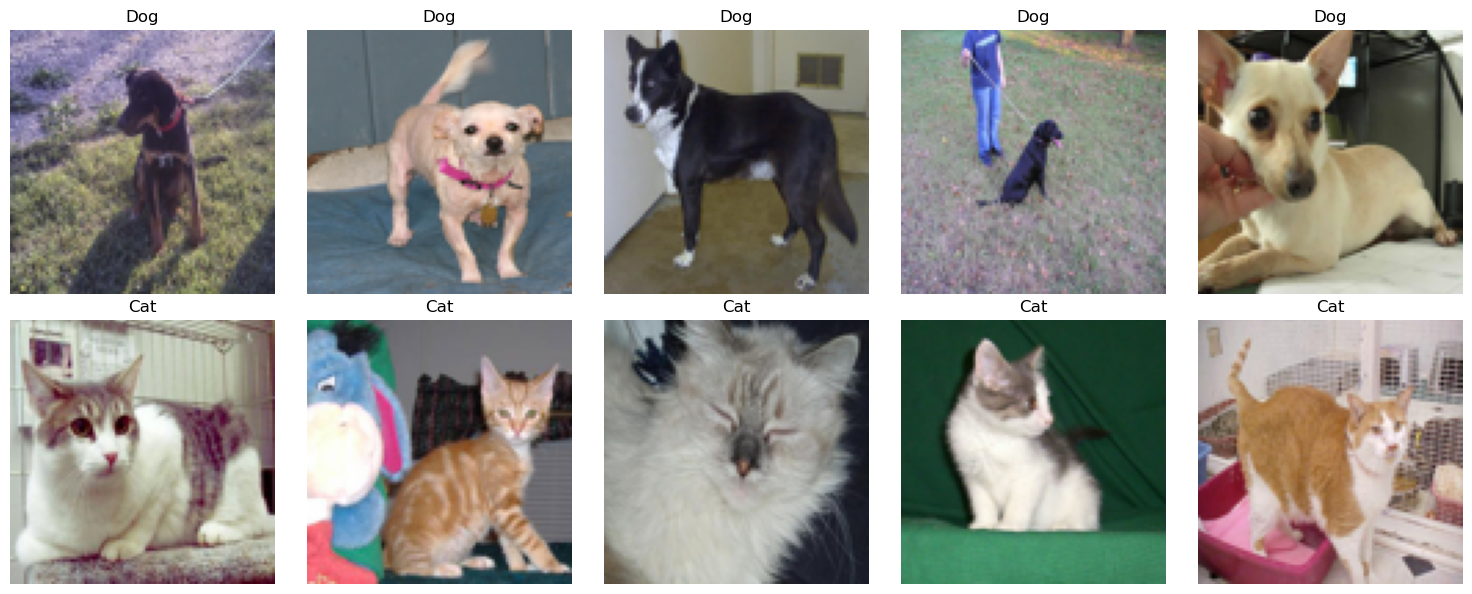

In [184]:
def show_samples(images, labels, n_samples=5):
    img_size = int(np.sqrt(images.shape[1] // 3))  # делим на 3 для RGB каналов
    
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples*3, 6))
    
    dog_indices = np.where(labels == 0)[0]
    cat_indices = np.where(labels == 1)[0]
    
    for i in range(n_samples):
        idx = dog_indices[i]
        img = images[idx].reshape(img_size, img_size, 3).astype(np.uint8) 
        axes[0, i].imshow(img)  B
        axes[0, i].set_title("Dog")
        axes[0, i].axis('off')
    
    for i in range(n_samples):
        idx = cat_indices[i]
        img = images[idx].reshape(img_size, img_size, 3).astype(np.uint8) 
        axes[1, i].imshow(img)  
        axes[1, i].set_title("Cat")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_samples(X_train, y_train)

In [185]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Классификатор без PCA

In [186]:
svm_no_pca = LinearSVC(C=1, random_state=777, max_iter=1000)
svm_no_pca.fit(X_train_scaled, y_train)
y_pred_svm = svm_no_pca.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"LinearSVC точность: {accuracy_svm:.4f}")
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred_svm, target_names=['Собака', 'Кошка']))

LinearSVC точность: 0.5650

Отчет о классификации LinearSVC:
              precision    recall  f1-score   support

      Собака       0.56      0.53      0.54       195
       Кошка       0.57      0.60      0.58       205

    accuracy                           0.56       400
   macro avg       0.56      0.56      0.56       400
weighted avg       0.56      0.56      0.56       400



/opt/homebrew/Caskroom/miniconda/base/envs/py39/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [187]:
logreg_no_pca = LogisticRegression(random_state=777, max_iter=1000)
logreg_no_pca.fit(X_train_scaled, y_train)
y_pred_logreg = logreg_no_pca.predict(X_test_scaled)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

print(f"\nLogistic Regression точность: {accuracy_logreg:.4f}")
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred_logreg, target_names=['Собака', 'Кошка']))


Logistic Regression точность: 0.5550

Отчет о классификации Logistic Regression:
              precision    recall  f1-score   support

      Собака       0.55      0.51      0.53       195
       Кошка       0.56      0.60      0.58       205

    accuracy                           0.56       400
   macro avg       0.55      0.55      0.55       400
weighted avg       0.55      0.56      0.55       400



In [ ]:
dt_no_pca = DecisionTreeClassifier(random_state=777)
dt_no_pca.fit(X_train_scaled, y_train)
y_pred_dt = dt_no_pca.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)


print(f"\nDecision Tree точность: {accuracy_dt:.4f}")
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred_dt, target_names=['Собака', 'Кошка']))



Decision Tree точность: 0.5050

Отчет о классификации Decision Tree:
              precision    recall  f1-score   support

      Собака       0.49      0.47      0.48       195
       Кошка       0.52      0.54      0.53       205

    accuracy                           0.51       400
   macro avg       0.50      0.50      0.50       400
weighted avg       0.50      0.51      0.50       400



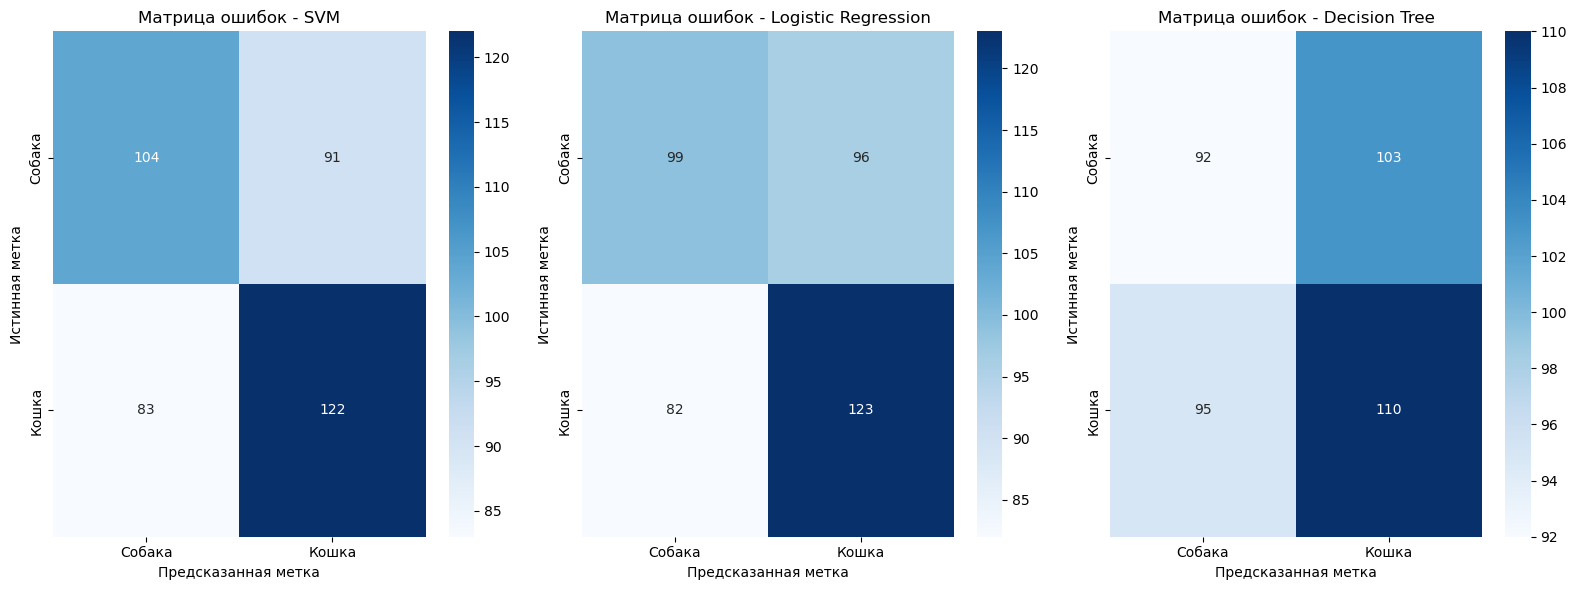

In [189]:
# матрицы ошибок
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Собака', 'Кошка'],
            yticklabels=['Собака', 'Кошка'], ax=axes[0])
axes[0].set_title('Матрица ошибок - SVM')
axes[0].set_ylabel('Истинная метка')
axes[0].set_xlabel('Предсказанная метка')

cm_logreg = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Собака', 'Кошка'],
            yticklabels=['Собака', 'Кошка'], ax=axes[1])
axes[1].set_title('Матрица ошибок - Logistic Regression')
axes[1].set_ylabel('Истинная метка')
axes[1].set_xlabel('Предсказанная метка')

cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Собака', 'Кошка'],
            yticklabels=['Собака', 'Кошка'], ax=axes[2])
axes[2].set_title('Матрица ошибок - Decision Tree')
axes[2].set_ylabel('Истинная метка')
axes[2].set_xlabel('Предсказанная метка')

plt.tight_layout()
plt.show()

## Классификатор с PCA

In [190]:
pca = PCA(n_components=0.90, random_state=777)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Исходная размерность пространства признаков: {X_train.shape[1]}")
print(f"Размерность после применения PCA: {X_train_pca.shape[1]}")
print(f"Сохраненная дисперсия: {np.sum(pca.explained_variance_ratio_):.4f}")

Исходная размерность пространства признаков: 27648
Размерность после применения PCA: 206
Сохраненная дисперсия: 0.9003


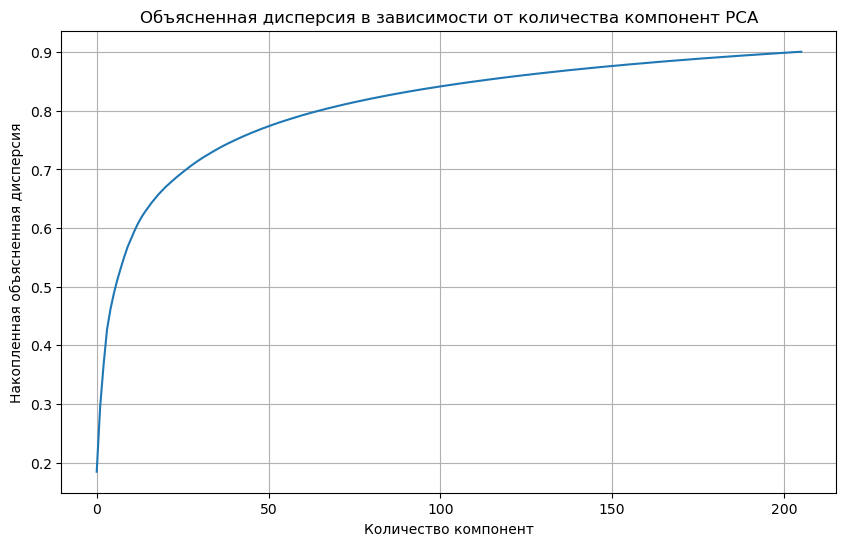

In [191]:
# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Количество компонент')
plt.ylabel('Накопленная объясненная дисперсия')
plt.title('Объясненная дисперсия в зависимости от количества компонент PCA')
plt.grid(True)
plt.show()

In [ ]:

print("обучение SVM с PCA...")
svm_pca = LinearSVC(C=1, random_state=777, max_iter=1000)
svm_pca.fit(X_train_pca, y_train)

print("\nобучение логистической регрессии с PCA...")
lr_pca = LogisticRegression(random_state=777, max_iter=1000)
lr_pca.fit(X_train_pca, y_train)

print("\nобучение дерева решений с PCA...")
dt_pca = DecisionTreeClassifier(random_state=777)
dt_pca.fit(X_train_pca, y_train)

# оцениваем все модели на тестовом наборе
y_pred_svm_pca = svm_pca.predict(X_test_pca)
y_pred_lr_pca = lr_pca.predict(X_test_pca)
y_pred_dt_pca = dt_pca.predict(X_test_pca)

accuracy_svm_pca = accuracy_score(y_test, y_pred_svm_pca)
accuracy_lr_pca = accuracy_score(y_test, y_pred_lr_pca)
accuracy_dt_pca = accuracy_score(y_test, y_pred_dt_pca)

print("\nРезультаты классификации с PCA:")
print(f"Точность SVM с PCA: {accuracy_svm_pca:.4f}")
print(f"Точность Logistic Regression с PCA: {accuracy_lr_pca:.4f}")
print(f"Точность Decision Tree с PCA: {accuracy_dt_pca:.4f}")

print("\nОтчет о классификации SVM с PCA:")
print(classification_report(y_test, y_pred_svm_pca, target_names=['Собака', 'Кошка']))

print("\nОтчет о классификации Logistic Regression с PCA:")
print(classification_report(y_test, y_pred_lr_pca, target_names=['Собака', 'Кошка']))

print("\nОтчет о классификации Decision Tree с PCA:")
print(classification_report(y_test, y_pred_dt_pca, target_names=['Собака', 'Кошка']))

Training SVM with PCA...

Training Logistic Regression with PCA...

Training Decision Tree with PCA...

Результаты классификации с PCA:
Точность SVM с PCA: 0.6075
Точность Logistic Regression с PCA: 0.6050
Точность Decision Tree с PCA: 0.5425

Отчет о классификации SVM с PCA:
              precision    recall  f1-score   support

      Собака       0.59      0.63      0.61       195
       Кошка       0.62      0.59      0.60       205

    accuracy                           0.61       400
   macro avg       0.61      0.61      0.61       400
weighted avg       0.61      0.61      0.61       400


Отчет о классификации Logistic Regression с PCA:
              precision    recall  f1-score   support

      Собака       0.59      0.62      0.60       195
       Кошка       0.62      0.59      0.60       205

    accuracy                           0.60       400
   macro avg       0.61      0.61      0.60       400
weighted avg       0.61      0.60      0.60       400


Отчет о классифика

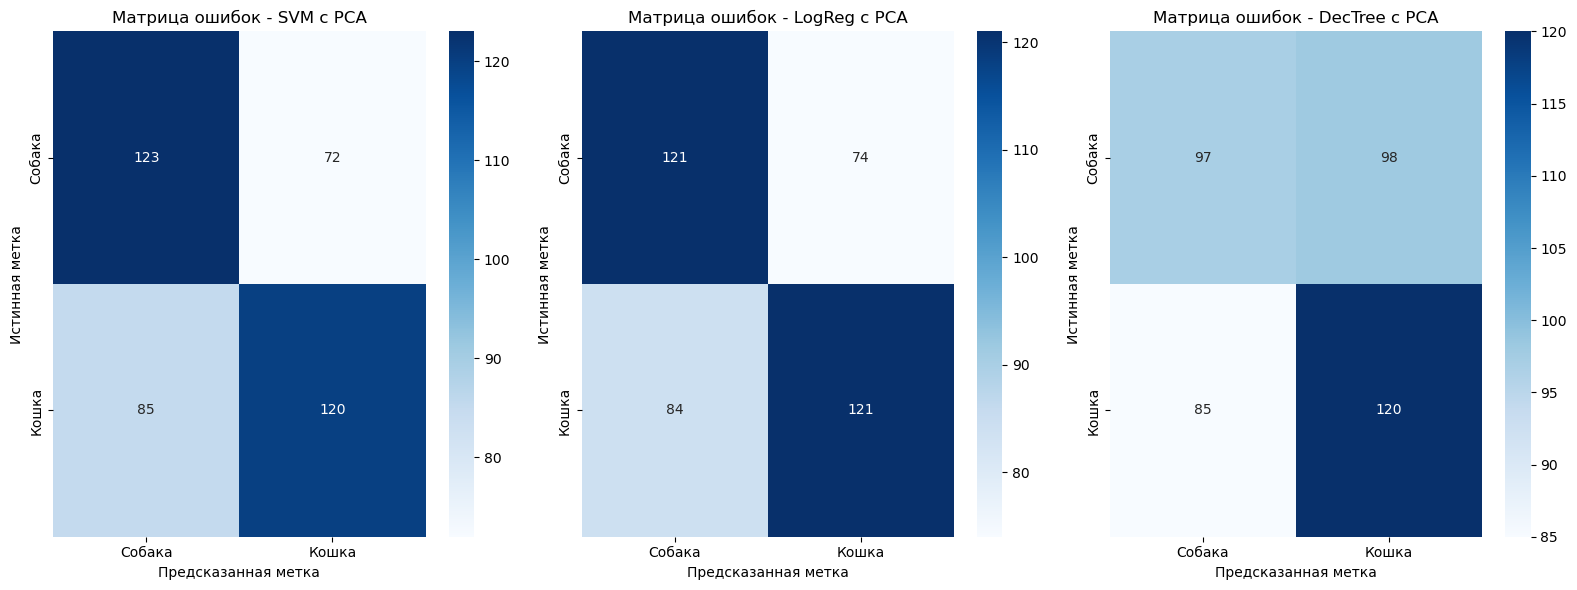

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

cm_svm = confusion_matrix(y_test, y_pred_svm_pca)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Собака', 'Кошка'],
            yticklabels=['Собака', 'Кошка'], ax=ax1)
ax1.set_title('Матрица ошибок - SVM с PCA')
ax1.set_ylabel('Истинная метка')
ax1.set_xlabel('Предсказанная метка')

cm_lr = confusion_matrix(y_test, y_pred_lr_pca)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Собака', 'Кошка'],
            yticklabels=['Собака', 'Кошка'], ax=ax2)
ax2.set_title('Матрица ошибок - LogReg с PCA')
ax2.set_ylabel('Истинная метка')
ax2.set_xlabel('Предсказанная метка')

cm_dt = confusion_matrix(y_test, y_pred_dt_pca)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Собака', 'Кошка'],
            yticklabels=['Собака', 'Кошка'], ax=ax3)
ax3.set_title('Матрица ошибок - DecTree с PCA')
ax3.set_ylabel('Истинная метка')
ax3.set_xlabel('Предсказанная метка')

plt.tight_layout()
plt.show()

## Сравнение результатов

In [194]:
print(f"Сокращение размерности: {X_train.shape[1]} → {X_train_pca.shape[1]} признаков")
print(f"Процент сокращения: {(1 - X_train_pca.shape[1]/X_train.shape[1]) * 100:.2f}%")

Сокращение размерности: 27648 → 206 признаков
Процент сокращения: 99.25%


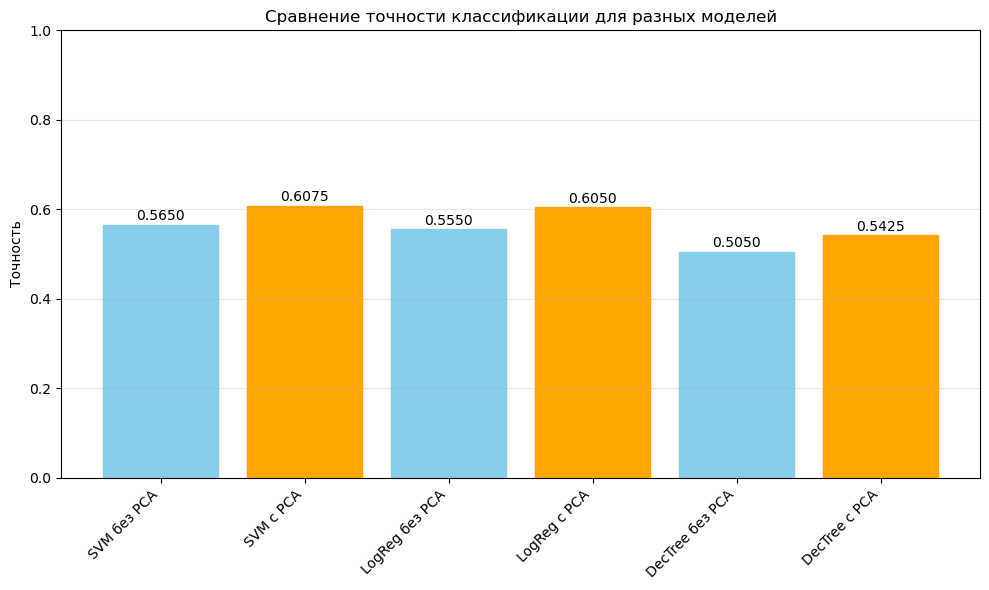

In [ ]:
# сравнение с помощью графика 
methods = ['SVM без PCA', 'SVM с PCA', 'LogReg без PCA', 'LogReg с PCA', 'DecTree без PCA', 'DecTree с PCA']
accuracies = [accuracy_svm, accuracy_svm_pca, 
              accuracy_logreg, accuracy_lr_pca,
              accuracy_dt, accuracy_dt_pca]

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, accuracies)
plt.ylim(0, 1.0)
plt.title('Сравнение точности классификации для разных моделей')
plt.ylabel('Точность')
plt.xticks(rotation=45, ha='right')

# цвета для каждой модели
colors = ['skyblue', 'orange'] * 3
for bar, color in zip(bars, colors):
    bar.set_color(color)

# значения на верху
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout() 
plt.show()

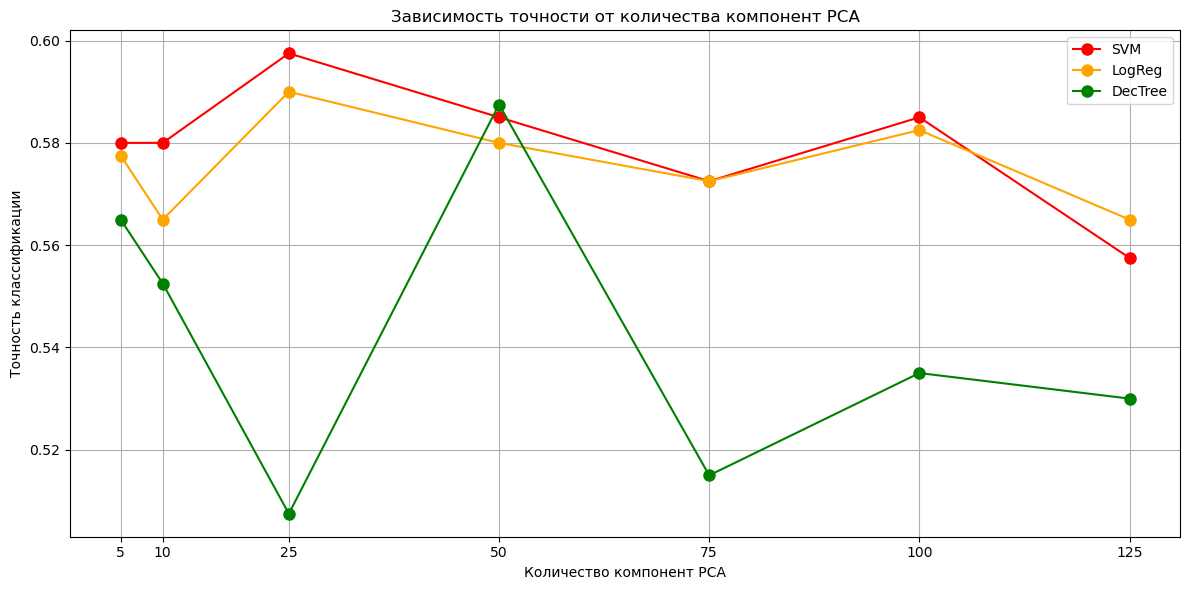

In [197]:
# тест разного количества компонент PCA
component_numbers = [5, 10, 25, 50, 75, 100, 125]
accuracies_svm = []
accuracies_lr = []
accuracies_dt = []

for n_comp in component_numbers:
    # Если компонент больше чем максимальное число, пропускаем
    if n_comp > min(X_train.shape[0], X_train.shape[1]):
        continue
    
    # Применяем PCA с заданным числом компонент
    pca_test = PCA(n_components=n_comp, random_state=777)
    X_train_pca_test = pca_test.fit_transform(X_train)
    X_test_pca_test = pca_test.transform(X_test)
    

    svm_pca_test = LinearSVC(C=1, random_state=777, max_iter=2000)
    svm_pca_test.fit(X_train_pca_test, y_train)
    y_pred_svm = svm_pca_test.predict(X_test_pca_test)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    accuracies_svm.append(accuracy_svm)
    
    lr_pca_test = LogisticRegression(random_state=777, max_iter=2000)
    lr_pca_test.fit(X_train_pca_test, y_train)
    y_pred_lr = lr_pca_test.predict(X_test_pca_test)
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    accuracies_lr.append(accuracy_lr)
    
    dt_pca_test = DecisionTreeClassifier(random_state=777)
    dt_pca_test.fit(X_train_pca_test, y_train)
    y_pred_dt = dt_pca_test.predict(X_test_pca_test)
    accuracy_dt = accuracy_score(y_test, y_pred_dt)
    accuracies_dt.append(accuracy_dt)


# Построение графика
plt.figure(figsize=(12, 6))

plt.plot(component_numbers[:len(accuracies_svm)], accuracies_svm, 'o-', markersize=8, color='red', label='SVM')
plt.plot(component_numbers[:len(accuracies_lr)], accuracies_lr, 'o-', markersize=8, color='orange', label='LogReg')
plt.plot(component_numbers[:len(accuracies_dt)], accuracies_dt, 'o-', markersize=8, color='green', label='DecTree')

plt.xlabel('Количество компонент PCA')
plt.ylabel('Точность классификации')
plt.title('Зависимость точности от количества компонент PCA')
plt.grid(True)
plt.xticks(component_numbers[:len(accuracies_svm)])

min_acc = min(min(accuracies_svm), min(accuracies_lr), min(accuracies_dt))
max_acc = max(max(accuracies_svm), max(accuracies_lr), max(accuracies_dt))
padding = (max_acc - min_acc) * 0.05 
plt.ylim(min_acc - padding, max_acc + padding)

plt.legend()

plt.tight_layout()
plt.show()

У линейных моделей наблюдается классическая кривая с пиком на малом числе компонент (~25) и постепенным снижением при добавлении компонент
Это ожидаемое поведение: первые компоненты несут больше информации, последние больше шума

Линейные модели ведут себя схоже
DecTree более нестабилен и имеет резкий пик при ~50 компонентах - деревья чувствительны к изменению пространства признаков

Добавление слишком большого числа компонент (>50) не улучшает результаты
SVM достигает максимума при ~25 компонентах, а не при максимальном количестве, что подтверждает пользу сокращения размерности

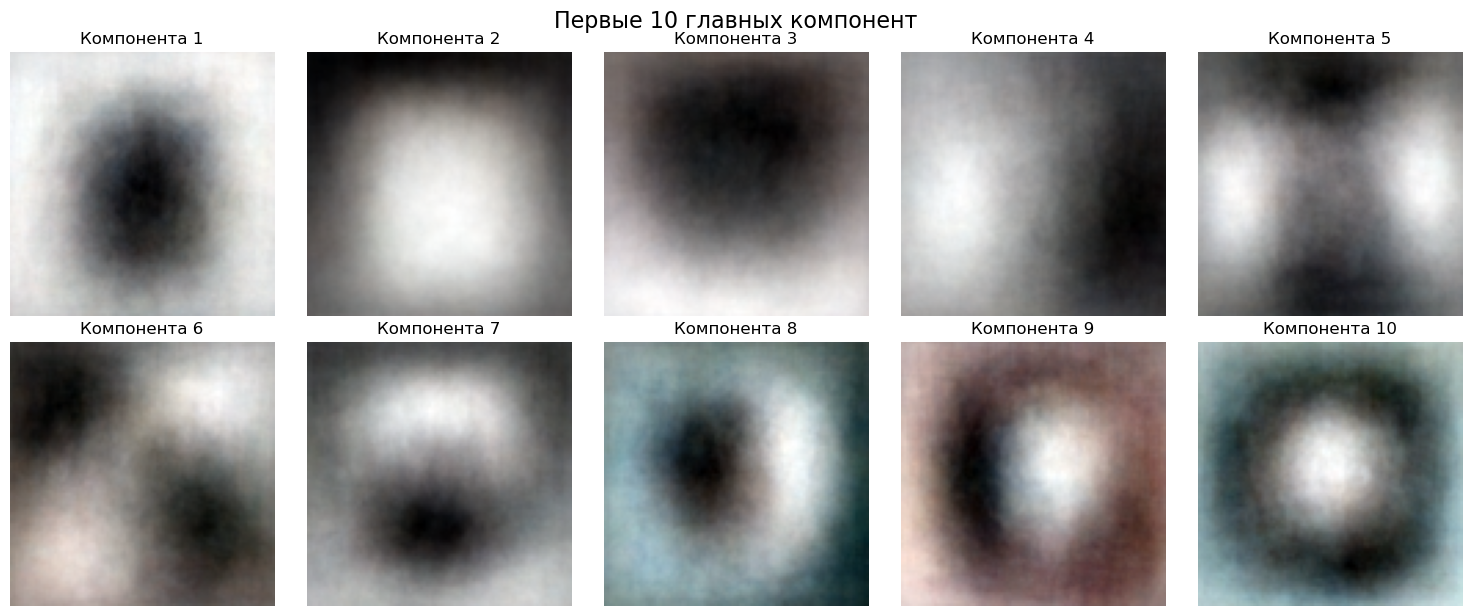

In [199]:
# Визуализация первых 10 главных компонент
def plot_principal_components(pca, img_shape, n_components):
    n_components = min(n_components, pca.components_.shape[0])
    
    # Создаем сетку для отображения компонент
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i in range(n_components):
        # Получаем i-ю главную компоненту и преобразуем в RGB формат
        component = pca.components_[i].reshape(img_shape[0], img_shape[1], 3)
        
        # Нормализуем каждый цветовой канал для отображения
        for c in range(3):
            component[:,:,c] = (component[:,:,c] - component[:,:,c].min()) / (component[:,:,c].max() - component[:,:,c].min())
        
        # Отображаем компоненту
        axes[i].imshow(component)
        axes[i].set_title(f'Компонента {i+1}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Первые 10 главных компонент', y=1.02, fontsize=16)
    plt.show()

img_shape = (96, 96, 3) # Changed to include RGB channels
plot_principal_components(pca, img_shape=img_shape, n_components=10)

## Выводы

- Мы построили классификатор для распознавания изображений кошек и собак.
- Проверили его работу с применением PCA и без него.
- PCA значительно сократил размерность признакового пространства, сохранив при этом 95% дисперсии.
- Сравнили точность классификации в обоих случаях.